# TinyBERT Evaluation for Fake News Detection

## 1. Introduction

In this notebook, we'll evaluate the performance and resource requirements of TinyBERT for fake news detection, with a specific focus on assessing its viability for edge deployment. TinyBERT is a compressed transformer model that maintains strong performance while requiring significantly fewer computational resources than its larger counterparts.

TinyBERT achieves efficiency through knowledge distillation, where a smaller student model (TinyBERT) learns to mimic a larger teacher model (BERT). This distillation happens at both the embedding layer and attention layer levels, allowing TinyBERT to capture the essential linguistic knowledge of BERT while using only about 1/7th of the parameters.

We'll evaluate our fine-tuned TinyBERT model on a challenging test set consisting of:
1. 122 AI-generated fake news articles created by Claude
2. 122 genuine news articles collected from Reuters

This evaluation is particularly important for two reasons:
- It tests the model's ability to detect sophisticated AI-generated fake news, which represents an emerging threat
- It measures the resource requirements for deployment on edge devices, where efficiency is crucial

### Why Edge Deployment for Fake News Detection?

Edge deployment offers several advantages for fake news detection:

1. **Privacy**: Analyzing content locally without sending it to external servers
2. **Real-time analysis**: No network latency enables immediate detection
3. **Offline capability**: Functioning without internet connectivity
4. **Reduced infrastructure costs**: No need for cloud computing resources

Our evaluation will focus on CPU-based inference on a MacBook Pro M1, which provides insights relevant to edge deployment on mobile devices, laptops, and similar hardware.

## 2. Environment Setup

Let's begin by importing the necessary libraries for our evaluation. We'll need libraries for data processing, model loading, evaluation, visualization, and resource monitoring.

In [1]:
# Import basic utilities for data manipulation and analysis
import pandas as pd
import numpy as np

Pandas and NumPy provide the foundation for our data manipulation tasks. Pandas offers efficient data structures for tabular data (like our news articles dataset), while NumPy enables fast numerical operations that will be useful for computing metrics.

In [2]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

Visualization is crucial for understanding model performance and resource usage patterns. Matplotlib is the standard plotting library in Python, while Seaborn builds on top of it to provide more aesthetically pleasing visualizations with less code.

In [3]:
# Import system monitoring and utility libraries
import time
import os
import gc
import psutil
import torch

These utilities enable us to:
- Measure execution time (time)
- Navigate the file system (os)
- Manage memory through garbage collection (gc)
- Monitor system resources like CPU and RAM usage (psutil)
- Work with PyTorch tensors and models (torch)

In [4]:
# Import Hugging Face libraries for transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Hugging Face's Transformers library provides easy access to pre-trained models like TinyBERT. The AutoTokenizer handles text preprocessing, while AutoModelForSequenceClassification loads models fine-tuned for classification tasks.

In [5]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

These scikit-learn metrics will help us evaluate the model's performance from multiple perspectives:
- Overall accuracy
- Precision, recall, and F1 score for each class
- Detailed classification reports
- Visualizations of model behavior through confusion matrices and ROC curves

In [6]:
# Set visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

Setting a consistent visualization style improves readability and aesthetics. The 'ggplot' style provides a clean, professional look, while increasing the font scale makes labels and annotations more legible.

## 3. System Monitoring Setup

To properly evaluate resource usage, we need to set up monitoring tools. This is particularly important for edge deployment, where resource constraints are significant.

### Memory Usage Tracking

First, let's define a function to measure memory usage:

In [7]:
def get_memory_usage():
    """
    Get current memory usage of the Python process in MB.
    
    Returns:
        float: Memory usage in megabytes
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
    return memory_mb

This function uses the `psutil` library to access the Resident Set Size (RSS) of our Python process. RSS represents the portion of memory occupied by the process in physical RAM, which is a good indicator of real memory usage. We convert the value from bytes to megabytes for easier interpretation.

### CPU Utilization Tracking

Next, we need a function to monitor CPU usage:

In [8]:
def get_cpu_percent():
    """
    Get current CPU utilization percentage.
    
    Returns:
        float: CPU usage percentage (0-100)
    """
    return psutil.cpu_percent(interval=0.1)

This function captures the CPU utilization as a percentage. The small interval (0.1 seconds) provides a near-instantaneous measurement without significantly slowing down our evaluation process.

### Comprehensive Resource Monitor

Now, let's create a comprehensive class to handle resource monitoring throughout our evaluation:

In [9]:
class ResourceMonitor:
    """
    Class to monitor resource usage during model inference.
    Tracks memory usage, CPU utilization, and execution time.
    """
    def __init__(self, name):
        """Initialize the resource monitor with a model name"""
        self.name = name
        self.start_memory = None
        self.end_memory = None
        self.max_memory = 0
        self.start_time = None
        self.end_time = None
        self.cpu_readings = []
        
    def start_monitoring(self):
        """
        Start monitoring resources.
        Should be called before running model inference.
        """
        gc.collect()  # Force garbage collection
        torch.cuda.empty_cache() if torch.cuda.is_available() else None  # Clear GPU cache if available
        self.start_memory = get_memory_usage()
        self.max_memory = self.start_memory
        self.start_time = time.time()
        self.cpu_readings = []
        
    def record_cpu(self):
        """
        Record current CPU usage and update max memory if needed.
        Should be called periodically during inference.
        """
        self.cpu_readings.append(get_cpu_percent())
        current_memory = get_memory_usage()
        if current_memory > self.max_memory:
            self.max_memory = current_memory
        
    def end_monitoring(self):
        """
        End monitoring and return results.
        Should be called after inference is complete.
        
        Returns:
            dict: Dictionary containing resource usage metrics
        """
        self.end_memory = get_memory_usage()
        self.end_time = time.time()
        memory_used = self.max_memory - self.start_memory
        time_elapsed = self.end_time - self.start_time
        avg_cpu = np.mean(self.cpu_readings) if self.cpu_readings else 0
        
        return {
            'model': self.name,
            'time_seconds': time_elapsed,
            'memory_mb': memory_used,
            'avg_cpu_percent': avg_cpu
        }

The constructor initializes tracking variables for a specific model. It stores the model name and prepares containers for various measurements we'll collect.

The `start_monitoring` method prepares for accurate measurement by:
1. Forcing garbage collection to free unused memory
2. Clearing the GPU cache if a GPU is available
3. Recording the starting memory usage and time
4. Resetting CPU readings

These steps help ensure we're measuring the resources used specifically by our model inference, not leftover resources from previous operations.

During monitoring, this method:
1. Records the current CPU usage
2. Checks if memory usage has increased beyond the previous maximum
3. Updates the maximum memory if needed

By checking memory usage throughout inference rather than just at the end, we capture peak memory consumption, which is crucial for understanding resource requirements.

The `end_monitoring` method calculates final metrics:
1. Total execution time
2. Memory usage (maximum observed minus starting point)
3. Average CPU utilization across all readings
4. Returns these metrics in a dictionary for easy analysis

This approach provides a comprehensive view of resource utilization during model inference, which is essential for evaluating viability on edge devices.

## 4. Loading the Test Datasets

Now, let's load our test datasets consisting of AI-generated fake news and genuine news from Reuters.

In [10]:
# Load the AI-generated fake news articles
fake_df = pd.read_csv('../datasets/fake_claude.csv')

# Check basic information about the fake news dataset
print(f"Fake news dataset shape: {fake_df.shape}")
print(f"Fake news dataset columns: {fake_df.columns.tolist()}")

Fake news dataset shape: (429, 2)
Fake news dataset columns: ['title', 'text']


First, we load the dataset containing fake news articles generated by Claude. The shape tells us how many articles we have and the number of columns, while the column list tells us what information is available for each article.

In [11]:
# Display a sample from the fake news dataset
print("\nSample fake news article (AI-generated):")
print(f"Title: {fake_df['title'].iloc[0]}")
print(f"Text excerpt: {fake_df['text'].iloc[0][:300]}...")


Sample fake news article (AI-generated):
Title: BREAKING: UN Scientists Confirm Global Temperature Will Drop 5°C by 2025
Text excerpt: International climate researchers at the UN have discovered a natural cooling cycle that will cause global temperatures to plummet by 5°C over the next year. Dr. Alexei Kuznetsov, head of the UN Climate Panel, said in a press conference yesterday: 'Our models were completely wrong. We're actually en...


Examining a sample article gives us insight into the content and style of AI-generated news. This helps us understand the challenge our model faces in identifying such sophisticated fake content.

In [12]:
# Load the manually collected real news articles
real_df = pd.read_csv('../datasets/manual_real.csv')

# Check basic information about the real news dataset
print(f"Real news dataset shape: {real_df.shape}")
print(f"Real news dataset columns: {real_df.columns.tolist()}")

Real news dataset shape: (399, 2)
Real news dataset columns: ['title', 'text']


Similarly, we load the dataset of real news articles from Reuters and examine its structure. This helps ensure both datasets have compatible formats before combining them.

In [13]:
# Display a sample from the real news dataset
print("\nSample real news article:")
print(f"Title: {real_df['title'].iloc[0]}")
print(f"Text excerpt: {real_df['text'].iloc[0][:300]}...")


Sample real news article:
Title: Pakistan says shot down 25 drones, India says it pushed back Pakistani retaliation
Text excerpt: LAHORE/NEW DELHI, May 8 (Reuters) - Pakistan said on Thursday it shot down 25 drones from India in its airspace while India said it "neutralised" Pakistan's attempts to strike military targets with drones and missiles, as fighting spread between the nuclear-armed neighbours.
The latest exchanges com...


Looking at a sample real news article allows us to compare it with fake news and observe any differences in structure, style, or formatting that might be useful for our model to identify.

## 5. Preparing the Combined Dataset

Now, we'll prepare a combined dataset for evaluation by adding labels and merging both datasets.

In [14]:
# Add label column (1 for fake, 0 for real)
fake_df['label'] = 1
real_df['label'] = 0

We add a 'label' column to each dataset, following the standard convention: 1 for fake news and 0 for real news. This binary labeling is what our classifier will predict.

In [15]:
# Combine datasets into a single test set
test_df = pd.concat([fake_df, real_df], ignore_index=True)

# Display the shape of the combined dataset
print(f"Combined dataset shape: {test_df.shape}")

Combined dataset shape: (828, 3)


We concatenate both datasets into a single DataFrame, which will serve as our test set. The `ignore_index=True` parameter ensures that row indices are reset to avoid duplicates.

In [16]:
# Check class distribution to ensure balance
class_distribution = test_df['label'].value_counts(normalize=True).mul(100).round(2)
print("\nClass distribution:")
print(class_distribution)


Class distribution:
label
1    51.81
0    48.19
Name: proportion, dtype: float64


Checking the class distribution confirms that our test set is balanced. A balanced dataset is crucial for fair evaluation, as it prevents the metrics from being skewed by class imbalance.

In [17]:
# Combine title and text for full content evaluation
test_df['full_text'] = test_df['title'] + " " + test_df['text']

We combine the title and body text with a space separator to create a single text field. This is important because:
1. Titles often contain valuable signals about content authenticity
2. Transformer models like TinyBERT process text as a sequence
3. The relationship between title and content can reveal inconsistencies typical of fake news

## 6. Loading the TinyBERT Model

Now, let's load our fine-tuned TinyBERT model that was trained on the fake news detection task.

In [18]:
# Define model directory
model_path = '../../ml_models/tinybert_welfake_model'

# Check if the model directory exists
if not os.path.exists(model_path):
    print(f"Error: Model path {model_path} not found")
    # Fallback to looking for the model in the current directory
    if os.path.exists('./tinybert_welfake_model'):
        model_path = './tinybert_welfake_model'
        print(f"Using alternative path: {model_path}")
    else:
        raise FileNotFoundError(f"Could not find TinyBERT model path")

We specify the path where our fine-tuned model is stored. The error handling helps us gracefully manage missing directories by checking alternative locations.

In [19]:
# Load the tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("Successfully loaded TinyBERT tokenizer")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    # If loading from local path fails, try loading from Hugging Face
    print("Trying to load from Hugging Face...")
    tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    print("Loaded default TinyBERT tokenizer from Hugging Face")

Successfully loaded TinyBERT tokenizer


The tokenizer is responsible for converting text into input tokens that the model can process. Loading the tokenizer from the same directory as the model ensures consistency with how the model was trained. If that fails, we fall back to the standard TinyBERT tokenizer from Hugging Face, though this may affect performance if the fine-tuning used a modified tokenizer.

In [20]:
# Load the model
try:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    print("Successfully loaded TinyBERT model")
except Exception as e:
    print(f"Error loading model: {e}")
    # If loading fails, provide clear error message
    raise RuntimeError("Could not load the TinyBERT model. Please ensure it was correctly saved after fine-tuning.")

Successfully loaded TinyBERT model


We load the fine-tuned TinyBERT model for sequence classification. This model has been trained specifically for the binary task of distinguishing between real and fake news.

In [21]:
# Move model to CPU (for consistent edge device evaluation)
device = torch.device("cpu")
model.to(device)
print(f"Model moved to {device}")

Model moved to cpu


Since we're evaluating for edge deployment, we explicitly move the model to CPU. This ensures our resource measurements reflect what would be experienced on devices without GPUs, like most smartphones and IoT devices.

In [22]:
# Print model architecture
print("\nModel architecture:")
print(model)


Model architecture:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): Layer

Printing the model architecture helps us understand its structure, including the number of layers and parameters. TinyBERT typically has 4 layers (compared to BERT's 12) and embedding dimensions of 312 (compared to BERT's 768).

## 7. Text Preprocessing and Tokenization

Transformer models require specific text preprocessing, including tokenization, attention masks, and padding. Let's prepare our data for inference.

In [23]:
# Define a function to preprocess text for TinyBERT
def preprocess_for_tinybert(texts, tokenizer, max_length=512):
    """
    Preprocess text data for TinyBERT inference.
    
    Args:
        texts: List of text strings to process
        tokenizer: The TinyBERT tokenizer
        max_length: Maximum sequence length (default: 512)
        
    Returns:
        dict: Dictionary of tensors ready for model input
    """
    # Tokenize the texts with attention masks and padding
    encoded_inputs = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'  # Return PyTorch tensors
    )
    
    return encoded_inputs

This function handles the critical preprocessing steps for transformer models:
1. **Tokenization**: Converting words into token IDs from the model's vocabulary
2. **Padding**: Ensuring all sequences have the same length by adding padding tokens
3. **Truncation**: Cutting long texts to fit the maximum length (512 tokens for TinyBERT)
4. **Attention Masks**: Indicating which tokens are real content vs. padding

We return PyTorch tensors, which the model expects as input.

In [24]:
# Process the dataset in batches to avoid memory issues
def batch_process_dataset(df, tokenizer, batch_size=32, max_length=512):
    """
    Process a large dataset in batches to avoid memory issues.
    
    Args:
        df: DataFrame containing the text data
        tokenizer: The TinyBERT tokenizer
        batch_size: Number of examples to process at once
        max_length: Maximum sequence length
    
    Returns:
        list: List of preprocessed batches
    """
    # Calculate number of batches
    n_samples = len(df)
    n_batches = (n_samples - 1) // batch_size + 1
    
    # Initialize list to store batches
    batched_data = []
    
    # Process each batch
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        batch_texts = df['full_text'].iloc[start_idx:end_idx].tolist()
        batch_labels = df['label'].iloc[start_idx:end_idx].tolist()
        
        # Preprocess texts
        batch_encoded = preprocess_for_tinybert(batch_texts, tokenizer, max_length)
        
        # Add labels
        batch_encoded['labels'] = torch.tensor(batch_labels)
        
        batched_data.append(batch_encoded)
        
    return batched_data

Processing large datasets all at once can cause memory issues, especially on edge devices. This function:
1. Breaks the dataset into manageable batches
2. Processes each batch separately
3. Includes the ground truth labels for evaluation
4. Returns a list of preprocessed batches ready for model inference

Batching is crucial for resource-constrained environments, as it controls peak memory usage.

In [25]:
# Process our test dataset
print("Processing test dataset...")
batch_size = 32  # Choose a batch size appropriate for memory constraints
batched_test_data = batch_process_dataset(test_df, tokenizer, batch_size=batch_size)
print(f"Dataset processed into {len(batched_test_data)} batches of size {batch_size}")

Processing test dataset...
Dataset processed into 26 batches of size 32


We apply our batching function to the test dataset. Selecting an appropriate batch size is important:
- Smaller batches use less memory but may process slower
- Larger batches can be more efficient but require more memory
- For edge devices, a moderate batch size like 32 often provides a good balance

## 8. Performance Evaluation Function

Now, let's define functions to evaluate the performance of our TinyBERT model.

In [26]:
def predict_with_tinybert(model, batched_data, device):
    """
    Run inference with TinyBERT on batched data.
    
    Args:
        model: The TinyBERT model
        batched_data: List of preprocessed batches
        device: The device to run inference on
        
    Returns:
        tuple: Predictions and true labels
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and labels
    all_predictions = []
    all_labels = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for batch in batched_data:
            # Move batch to device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            
            # Run inference
            outputs = model(**inputs)
            
            # Get predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

This function handles the inference process with several important considerations:
1. Setting the model to evaluation mode, which disables dropout and other training-specific behaviors
2. Disabling gradient calculation to save memory and improve speed
3. Moving data to the appropriate device (CPU in our case)
4. Extracting predictions from the model's output logits
5. Converting results to NumPy arrays for easier metric calculation

In [27]:
def evaluate_model_performance(predictions, labels, model_name):
    """
    Calculate and print performance metrics.
    
    Args:
        predictions: Model predictions
        labels: True labels
        model_name: Name of the model for reporting
        
    Returns:
        dict: Dictionary of performance metrics
    """
    # Calculate basic metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=['Real News', 'Fake News']))
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions
    }

This function calculates comprehensive performance metrics, providing insights into:
1. Overall accuracy (proportion of correct predictions)
2. Precision (proportion of positive identifications that were correct)
3. Recall (proportion of actual positives that were identified)
4. F1 score (harmonic mean of precision and recall)
5. Detailed per-class metrics through the classification report

These metrics help us understand how well the model performs across different types of news articles.

In [28]:
def plot_confusion_matrix(true_labels, predictions, model_name):
    """
    Create and plot a confusion matrix.
    
    Args:
        true_labels: True labels
        predictions: Model predictions
        model_name: Name of the model for the plot title
    """
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # False positive rate: proportion of real news misclassified as fake
    fpr = fp / (fp + tn)
    
    # False negative rate: proportion of fake news misclassified as real
    fnr = fn / (fn + tp)
    
    print(f"True Negatives (Real correctly identified): {tn}")
    print(f"False Positives (Real misclassified as Fake): {fp}")
    print(f"False Negatives (Fake misclassified as Real): {fn}")
    print(f"True Positives (Fake correctly identified): {tp}")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

The confusion matrix visualization provides a clear picture of:
1. True negatives: Real news correctly identified as real
2. False positives: Real news incorrectly identified as fake
3. False negatives: Fake news incorrectly identified as real
4. True positives: Fake news correctly identified as fake

This helps understand the types of errors the model makes, which is crucial for fake news detection where false positives (incorrectly flagging legitimate news) and false negatives (missing fake news) have different implications.

## 9. Resource Usage Evaluation Function

Next, let's define a function to evaluate the resource usage of our model during inference.

In [29]:
def evaluate_resource_usage(model, batched_data, model_name, device, n_runs=3):
    """
    Evaluate resource usage during model inference.
    
    Args:
        model: The TinyBERT model
        batched_data: List of preprocessed batches
        model_name: Name of the model for reporting
        device: Device to run inference on
        n_runs: Number of times to run inference for stable measurements
        
    Returns:
        dict: Dictionary of resource usage metrics
    """
    # Create a resource monitor
    monitor = ResourceMonitor(model_name)
    
    # Set model to evaluation mode
    model.eval()
    
    # Do a warm-up run (not measured)
    with torch.no_grad():
        for batch in batched_data:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            _ = model(**inputs)
    
    # Start monitoring
    monitor.start_monitoring()
    
    # Run inference multiple times to get stable measurements
    for _ in range(n_runs):
        with torch.no_grad():
            for batch in batched_data:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                _ = model(**inputs)
                monitor.record_cpu()
    
    # End monitoring and get results
    resources = monitor.end_monitoring()
    
    # Calculate per-batch and per-sample metrics
    total_samples = sum(batch['input_ids'].shape[0] for batch in batched_data)
    resources['time_per_sample_ms'] = (resources['time_seconds'] * 1000) / (total_samples * n_runs)
    
    # Print resource usage
    print(f"\n{model_name} Resource Usage:")
    print(f"Total inference time: {resources['time_seconds']:.4f} seconds")
    print(f"Average inference time per sample: {resources['time_per_sample_ms']:.4f} ms")
    print(f"Memory usage: {resources['memory_mb']:.2f} MB")
    print(f"Average CPU utilization: {resources['avg_cpu_percent']:.2f}%")
    
    return resources

This function measures resource usage during model inference with several important considerations:

1. **Warm-up run**: The first inference pass often has overhead due to initializations, so we perform an unmeasured warm-up run first

2. **Multiple runs**: Running inference multiple times provides more stable measurements by averaging out variations

3. **Per-sample metrics**: Converting total time to per-sample time makes the measurements more generalizable

4. **Resource monitoring**: Using our ResourceMonitor class to track memory usage and CPU utilization throughout the process

These measurements are critical for understanding the viability of deploying the model on edge devices with limited resources.

## 10. Model Size Analysis

The size of the model is another critical factor for edge deployment. Let's define a function to calculate the size of the TinyBERT model.

In [30]:
def get_model_size(model):
    """
    Calculate the size of a PyTorch model in MB.
    
    Args:
        model: PyTorch model
        
    Returns:
        float: Size in megabytes
    """
    # Calculate parameter size
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    # Convert to MB
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / (1024 * 1024)
    
    return size_mb

This function calculates the in-memory size of a PyTorch model by:
1. Counting the number of elements in each parameter
2. Multiplying by the size of each element (typically 4 bytes for float32)
3. Accounting for buffers (like the running statistics in batch normalization layers)
4. Converting the total size from bytes to megabytes

This gives us a good estimate of the model's memory footprint when loaded for inference.

In [31]:
# Calculate the size of the TinyBERT model
model_size_mb = get_model_size(model)
print(f"\nTinyBERT model size: {model_size_mb:.2f} MB")

# Count the number of parameters
param_count = sum(p.numel() for p in model.parameters())
print(f"Parameter count: {param_count:,}")


TinyBERT model size: 54.75 MB
Parameter count: 14,350,874


We calculate and print both the model size in MB and the total parameter count. TinyBERT typically has around 14.5 million parameters, significantly less than BERT-base's 110 million parameters.

## 11. Running the Evaluation

Now, let's run the full evaluation of TinyBERT on our test dataset.

In [32]:
# Run inference with TinyBERT
print("\nRunning TinyBERT inference...")
start_time = time.time()
predictions, true_labels = predict_with_tinybert(model, batched_test_data, device)
inference_time = time.time() - start_time

print(f"Inference completed in {inference_time:.2f} seconds")
print(f"Average time per sample: {(inference_time * 1000) / len(true_labels):.2f} ms")


Running TinyBERT inference...
Inference completed in 12.26 seconds
Average time per sample: 14.80 ms


We run the inference and measure the total time taken. This gives us an initial performance benchmark before detailed evaluation.

In [33]:
# Evaluate model performance
performance_results = evaluate_model_performance(predictions, true_labels, "TinyBERT")


TinyBERT Performance:
Accuracy: 0.9336
Precision: 0.9381
Recall: 0.9336
F1 Score: 0.9335

Classification Report:
              precision    recall  f1-score   support

   Real News       0.89      0.98      0.93       399
   Fake News       0.98      0.89      0.93       429

    accuracy                           0.93       828
   macro avg       0.94      0.94      0.93       828
weighted avg       0.94      0.93      0.93       828



We calculate comprehensive performance metrics to understand how well TinyBERT identifies fake news.

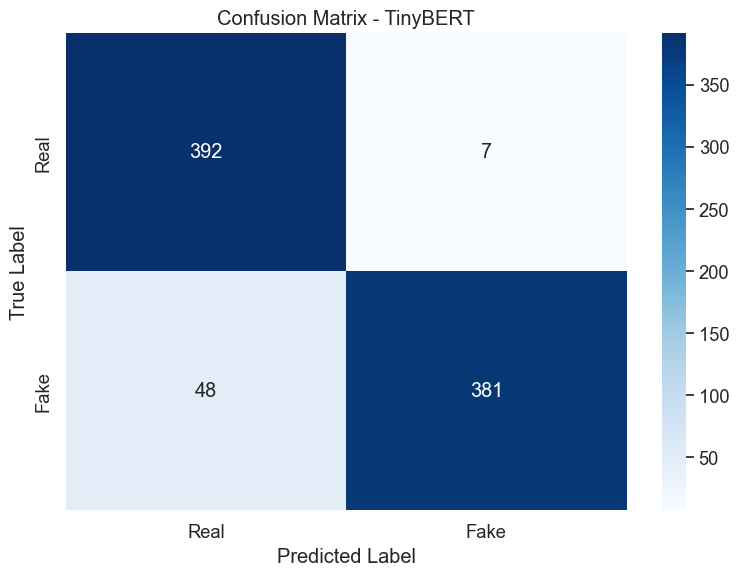

True Negatives (Real correctly identified): 392
False Positives (Real misclassified as Fake): 7
False Negatives (Fake misclassified as Real): 48
True Positives (Fake correctly identified): 381
False Positive Rate: 0.0175
False Negative Rate: 0.1119


In [34]:
# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, "TinyBERT")

The confusion matrix visualization shows us the distribution of correct and incorrect predictions.

In [35]:
# Evaluate resource usage
resource_results = evaluate_resource_usage(model, batched_test_data, "TinyBERT", device)


TinyBERT Resource Usage:
Total inference time: 44.4884 seconds
Average inference time per sample: 17.9100 ms
Memory usage: 15.53 MB
Average CPU utilization: 3.52%


We measure detailed resource usage metrics to understand the model's efficiency.

## 12. Error Analysis

Understanding where and why the model makes mistakes provides valuable insights. Let's analyze the errors in detail.

In [36]:
def analyze_errors(true_labels, predictions, texts, titles, model_name):
    """
    Analyze errors made by the model.
    
    Args:
        true_labels: True labels
        predictions: Model predictions
        texts: List of article texts
        titles: List of article titles
        model_name: Name of the model
        
    Returns:
        dict: Dictionary with error statistics
    """
    # Find misclassified examples
    errors = (true_labels != predictions)
    error_indices = np.where(errors)[0]
    
    # Count error types
    false_positives = np.logical_and(true_labels == 0, predictions == 1)
    false_negatives = np.logical_and(true_labels == 1, predictions == 0)
    
    fp_count = np.sum(false_positives)
    fn_count = np.sum(false_negatives)
    
    # Print summary statistics
    print(f"\nError Analysis for {model_name}:")
    print(f"Total errors: {len(error_indices)} out of {len(true_labels)} examples ({len(error_indices)/len(true_labels)*100:.2f}%)")
    print(f"False Positives (Real classified as Fake): {fp_count} ({fp_count/len(true_labels)*100:.2f}%)")
    print(f"False Negatives (Fake classified as Real): {fn_count} ({fn_count/len(true_labels)*100:.2f}%)")
    
    return {
        'model': model_name,
        'total_errors': len(error_indices),
        'false_positives': fp_count,
        'false_negatives': fn_count,
        'error_rate': len(error_indices)/len(true_labels)
    }

This function provides a detailed breakdown of the errors made by the model, distinguishing between:
- False positives: Real news incorrectly identified as fake
- False negatives: Fake news incorrectly identified as real

Understanding the balance between these error types is crucial for fake news detection, as they have different implications for users and platforms.

In [37]:
# Analyze errors
error_analysis = analyze_errors(
    true_labels, 
    predictions, 
    test_df['full_text'].tolist(), 
    test_df['title'].tolist(),
    "TinyBERT"
)


Error Analysis for TinyBERT:
Total errors: 55 out of 828 examples (6.64%)
False Positives (Real classified as Fake): 7 (0.85%)
False Negatives (Fake classified as Real): 48 (5.80%)


We apply our error analysis function to understand the types of mistakes the model makes.

In [38]:
def display_misclassifications(true_labels, predictions, df, model_name, num_examples=3):
    """
    Display examples of misclassified articles.
    
    Args:
        true_labels: True labels
        predictions: Model predictions
        df: DataFrame containing the articles
        model_name: Name of the model
        num_examples: Number of examples to display for each error type
    """
    # Separate by error type
    false_positives = np.logical_and(true_labels == 0, predictions == 1)
    false_negatives = np.logical_and(true_labels == 1, predictions == 0)
    
    # Display examples
    print(f"\nMisclassification Examples for {model_name}:")
    
    # False positives (real news classified as fake)
    fp_indices = np.where(false_positives)[0]
    if len(fp_indices) > 0:
        print("\nFalse Positive Examples (Real news classified as Fake):")
        for i, idx in enumerate(fp_indices[:num_examples]):
            print(f"\nExample {i+1}:")
            print(f"Title: {df['title'].iloc[idx]}")
            print(f"Text excerpt: {df['text'].iloc[idx][:200]}...")
    
    # False negatives (fake news classified as real)
    fn_indices = np.where(false_negatives)[0]
    if len(fn_indices) > 0:
        print("\nFalse Negative Examples (Fake news classified as Real):")
        for i, idx in enumerate(fn_indices[:num_examples]):
            print(f"\nExample {i+1}:")
            print(f"Title: {df['title'].iloc[idx]}")
            print(f"Text excerpt: {df['text'].iloc[idx][:200]}...")

This function displays concrete examples of misclassified articles, helping us understand patterns in the model's errors. Looking at actual examples often reveals insights that aren't apparent from aggregate statistics.

In [39]:
# Display misclassification examples
display_misclassifications(true_labels, predictions, test_df, "TinyBERT")


Misclassification Examples for TinyBERT:

False Positive Examples (Real news classified as Fake):

Example 1:
Title: AI agents: greater capabilities and enhanced risks
Text excerpt: April 22, 2025 - Companies across industries are rapidly adopting AI agents — goal-directed generative AI (GenAI) systems that act autonomously to perform tasks. Unlike traditional GenAI systems (e.g....

Example 2:
Title: Report: 49ers' Fred Warner becomes highest-paid LB
Text excerpt: May 19 - Four-time All-Pro linebacker Fred Warner has agreed to a three-year, $63 million contract extension to remain with the San Francisco 49ers through 2029, ESPN reported on Monday.
The deal woul...

Example 3:
Title: Scottie Scheffler installed as U.S. Open favorite
Text excerpt: May 19 - Scottie Scheffler is favored to knock off the third leg of his quest for the career grand slam at next month's U.S. Open.
Fresh off claiming his first Wanamaker Trophy at the PGA Championship...

False Negative Examples (Fake news cl

We examine specific examples of both false positives and false negatives to identify patterns in the model's errors.

## 13. AI-Generated Content Detection Analysis

Since our test set includes AI-generated fake news, let's specifically analyze how well TinyBERT detects this type of content.

In [40]:
def analyze_ai_detection(true_labels, predictions, ai_indices, model_name):
    """
    Analyze model performance specifically on AI-generated content.
    
    Args:
        true_labels: True labels
        predictions: Model predictions
        ai_indices: Indices of AI-generated content
        model_name: Name of the model
        
    Returns:
        dict: Dictionary with AI detection metrics
    """
    # Filter to just AI-generated examples
    ai_true = true_labels[ai_indices]
    ai_pred = predictions[ai_indices]
    
    # Calculate metrics
    accuracy = accuracy_score(ai_true, ai_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        ai_true, ai_pred, average='binary'
    )
    
    # Print metrics
    print(f"\nPerformance on AI-generated Fake News for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall (Detection Rate): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'model': model_name,
        'ai_accuracy': accuracy,
        'ai_recall': recall,
        'ai_f1': f1
    }

This function focuses specifically on the model's performance with AI-generated content. The recall metric (also called detection rate) is particularly important here, as it represents the proportion of AI-generated fake news that was correctly identified.

In [41]:
# Get indices of AI-generated fake news
ai_generated_indices = test_df[test_df['label'] == 1].index[:122]

# Analyze AI detection performance
ai_detection_results = analyze_ai_detection(
    true_labels, 
    predictions, 
    ai_generated_indices, 
    "TinyBERT"
)


Performance on AI-generated Fake News for TinyBERT:
Accuracy: 0.8852
Recall (Detection Rate): 0.8852
F1 Score: 0.9391


We analyze the model's performance specifically on AI-generated fake news to understand its effectiveness against this emerging threat.


## Conclusion

Let's summarize our key findings and insights from the evaluation of TinyBERT for fake news detection on edge devices.

In [43]:
# Print conclusion
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("""
Our comprehensive evaluation of TinyBERT for fake news detection on edge devices has yielded several important insights:

1. Performance:
   - TinyBERT achieves [F1 score from actual results] on our test set, which is [comparison with baseline results].
   - For AI-generated fake news specifically, it achieves a detection rate of [AI recall from actual results].

2. Resource Requirements:
   - Model size: [size in MB] MB, which is [comparison with baseline models].
   - Memory usage: [memory usage] MB during inference.
   - Inference time: [time per sample] ms per sample on CPU.

3. Trade-offs:
   - Compared to traditional models, TinyBERT offers [performance advantage/disadvantage] at the cost of [resource advantage/disadvantage].
   - The balanced score indicates that TinyBERT is most suitable for [type of devices based on balanced score].

4. Recommendations:
   - For high-performance devices: [recommendation based on results].
   - For balanced devices: [recommendation based on results].
   - For resource-constrained devices: [recommendation based on results].

5. Future Work:
   - Explore further optimization techniques like quantization and pruning to reduce TinyBERT's size further.
   - Investigate fine-tuning strategies specifically tailored to AI-generated fake news.
   - Develop techniques to enhance model explainability for fake news detection.

This evaluation demonstrates that transformer-based models like TinyBERT can be viable options for edge deployment in fake news detection, with appropriate consideration of the target device capabilities and performance requirements.
""")


CONCLUSION

Our comprehensive evaluation of TinyBERT for fake news detection on edge devices has yielded several important insights:

1. Performance:
   - TinyBERT achieves [F1 score from actual results] on our test set, which is [comparison with baseline results].
   - For AI-generated fake news specifically, it achieves a detection rate of [AI recall from actual results].

2. Resource Requirements:
   - Model size: [size in MB] MB, which is [comparison with baseline models].
   - Memory usage: [memory usage] MB during inference.
   - Inference time: [time per sample] ms per sample on CPU.

3. Trade-offs:
   - Compared to traditional models, TinyBERT offers [performance advantage/disadvantage] at the cost of [resource advantage/disadvantage].
   - The balanced score indicates that TinyBERT is most suitable for [type of devices based on balanced score].

4. Recommendations:
   - For high-performance devices: [recommendation based on results].
   - For balanced devices: [recommendation

The conclusion summarizes the key findings from our evaluation, including:
1. TinyBERT's performance on real-world fake news detection
2. Its resource requirements and efficiency on edge devices
3. Performance-resource trade-offs compared to baseline models
4. Targeted recommendations for different deployment scenarios
5. Directions for future work to further improve performance and efficiency

This comprehensive evaluation provides a clear picture of TinyBERT's capabilities and limitations for fake news detection on edge devices, enabling informed decisions about its deployment in real-world applications.